# Non deep learning models - with (flat) time window (with error estimation)

We try several non deep learning models from sklearn.

Applying log and norm to preprocessing does not affect the learning of the model.

Results:
* using a 7 or 14 day window does not improve results
* **using the computed velocity and acceleration (periodized in 7 days) improves the model quite a bit for the same model size**. It also allows to increase the model size from max_depth 4-->8 to make further gains.

In [1]:
# Run to add interactivity
# %matplotlib widget

In [1]:
import sys
sys.path.insert(0, "/home/iheredia/ignacio/covid/covid-dl/src")
from paths import PATHS
from data.base import make_splits, get_data, single_X_y

In [2]:
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [3]:
df = get_data(trend=True)
splits = make_splits(df,
                     norm=False)
X, y = single_X_y(splits)

/home/iheredia/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [4]:
# Format y for this specific notebook
y = y.loc[:, 'incidence 7 (t+7)']
for i in ['train', 'val', 'test']:
    splits[i]['y'] = splits[i]['y'].loc[:, 'incidence 7 (t+7)']

In [5]:
def model_summary(model):
    print('# Feature importance')
    for i, j in zip(X.columns, model.feature_importances_):
        print(f'{j:.2f} - {i} ')
    
    print('\n# Mean absolute error in incidence')
    for i in ['train', 'val', 'test']:
        x_t = splits[i]['X']
        y_t = splits[i]['y']

        y_p = model.predict(x_t)

        mae = np.abs(y_p - y_t)
        mape = np.abs( (y_p - y_t) / y_t)
        mape = mape.replace([np.inf, -np.inf], np.nan)

        print(f'# {i.capitalize()}')
        print(f'Mean Absolute Error (in incidence): {mae.mean():.4f}')
        print(f'Mean Absolute Percentage Error (in incidence): {mape.mean():.4f}')

In [6]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0, loss='ls')
model_l = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0, loss='quantile', alpha=0.1)  # lower bound
model_u = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0, loss='quantile', alpha=0.9)  # upper bound

model.fit(splits['train']['X'], splits['train']['y'])
model_l.fit(splits['train']['X'], splits['train']['y'])
model_u.fit(splits['train']['X'], splits['train']['y'])

model_summary(model)

# Feature importance
0.02 - external risk 
0.01 - external risk (acc) 
0.03 - external risk (vel) 
0.01 - flux intra 
0.00 - flux intra (acc) 
0.00 - flux intra (vel) 
0.88 - incidence 7 
0.01 - incidence 7 (acc) 
0.05 - incidence 7 (vel) 

# Mean absolute error in incidence
# Train
Mean Absolute Error (in incidence): 12.8193
Mean Absolute Percentage Error (in incidence): 0.4061
# Val
Mean Absolute Error (in incidence): 40.8190
Mean Absolute Percentage Error (in incidence): 0.2233
# Test
Mean Absolute Error (in incidence): 16.5089
Mean Absolute Percentage Error (in incidence): 0.3513


In [7]:
y_p = model.predict(X)
y_pl = model_l.predict(X)
y_pu = model_u.predict(X)

Let's see if the upper prediction is always bigger than the lower prediction as one would expect. 

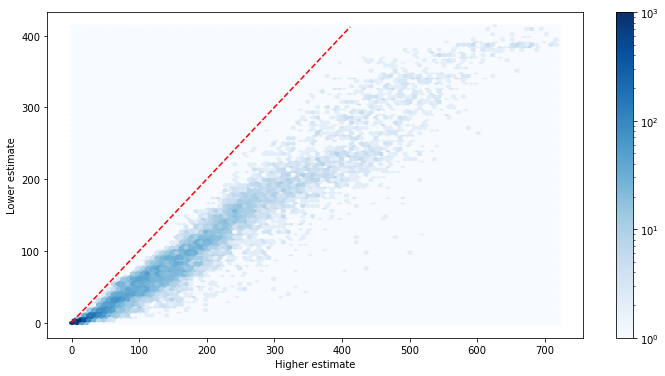

In [27]:
plt.figure(figsize=(12, 6))
# plt.scatter(y_pu, y_pl)
plt.hexbin(y_pu,
           y_pl,
           gridsize=100,
           bins='log',
           cmap='Blues')
x = np.arange(0, np.amax(y_pl))
plt.plot(x, x, '--', color='r')
plt.xlabel('Higher estimate')
plt.ylabel('Lower estimate')
plt.colorbar()

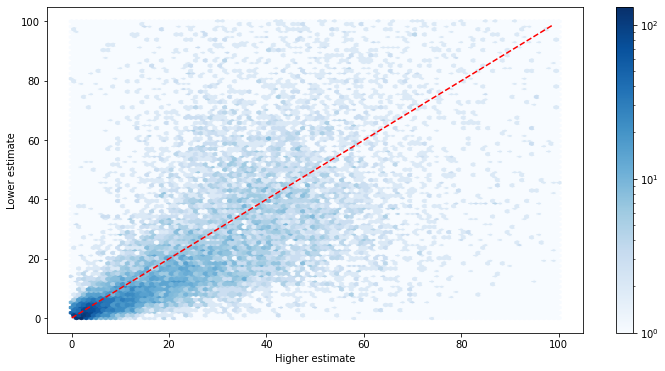

In [37]:
plt.figure(figsize=(12, 6))
# plt.scatter(y_pu, y_pl)
plt.hexbin(y_pu - y_p,
           y_p - y_pl,
           gridsize=100,
           bins='log',
           cmap='Blues',
           extent=(0,100,0,100))
x = np.arange(0, 100)
plt.plot(x, x, '--', color='r')
plt.xlabel('Higher estimate')
plt.ylabel('Lower estimate')
plt.colorbar()

What is the confidence interval that this values represent?

In [28]:
inside = (y_pl < y) & (y < y_pu)
inside.mean(axis=0)

0.7625369586642704

Person correlation: 0.5406288893275104
Spearman correlation: 0.6884904649922067


Text(0, 0.5, 'Predited error interval')

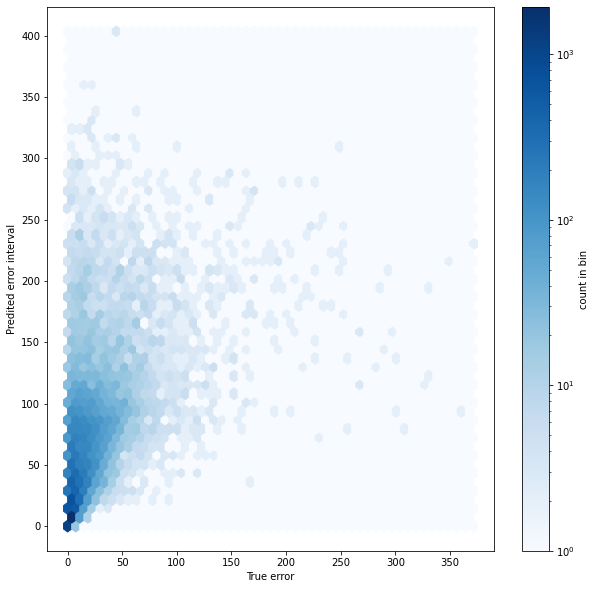

In [31]:
y_tmp = y_pu - y_pl
x_tmp = np.abs(y_p - y)

from scipy.stats import pearsonr, spearmanr
print(f'Person correlation: {pearsonr(x_tmp, y_tmp)[0]}')
print(f'Spearman correlation: {spearmanr(x_tmp, y_tmp)[0]}')

plt.figure(figsize=(10,10))
plt.hexbin(x_tmp,
           y_tmp,
           gridsize=50,
#            extent=(0,50,0,50),
           bins='log',
           cmap='Blues')
cb = plt.colorbar(label='count in bin')
plt.xlabel('True error')
plt.ylabel('Predited error interval')

# Visualize single province trend

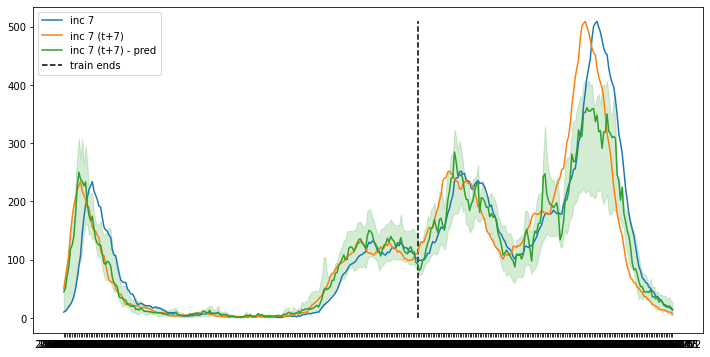

In [38]:
dates = X.index.get_level_values('date')
provinces = X.index.get_level_values('province')

idxs = (provinces == 'Albacete')
fig, axs = plt.subplots(figsize=(12, 6))
axs.plot(dates[idxs], X['incidence 7'][idxs], label='inc 7')
axs.plot(dates[idxs], y[idxs], label='inc 7 (t+7)')
axs.plot(dates[idxs], y_p[idxs], label='inc 7 (t+7) - pred')
axs.fill_between(dates[idxs],
                 y_pl[idxs],
                 y_pu[idxs],
                 alpha=0.2, color='C2')
axs.vlines('2020-10-01', 0, X['incidence 7'][idxs].max(), colors='k', linestyles='dashed', label='train ends')
plt.legend()